# Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets

from math import inf
from collections import OrderedDict
from abc import ABC, abstractmethod

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Реализуем свои классы решающих деревьев

### Базовый класс дерева

#### Узел

In [2]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

    def predict(self, X):
        if X[self.index] <= self.t:
            return self.true_branch.predict(X)
        else:
            return self.false_branch.predict(X)

#### Лист

In [3]:
class Leaf(ABC):
    def __init__(self, labels):
        self.labels = labels
        self._get_prediction(labels)

    def predict(self, X=None):
        return self.prediction

    @abstractmethod
    def _get_prediction(self, labels):
        self.prediction = None

#### Класс для обрезки дерева.

Нужен для реализации параметра max_leaf_count

In [4]:
class TreeCutter:

    def cut_leafs(self, tree, n, cut_last_node=False):
        self._level_list = OrderedDict()
        self._read_node(tree)
        n = self._cut_leafs(n)
        if n > 0 and cut_last_node:
            leaf = self._create_leaf_from_node(tree)
            if leaf is not None:
                return leaf

        return tree

    def _read_node(self, node, parent=None, level=0):
        if isinstance(node, Node):
            self._add_node(node, parent, level)

            if isinstance(node.true_branch, Node):
                self._read_node(node.true_branch, node, level+1)

            if isinstance(node.false_branch, Node):
                self._read_node(node.false_branch, node, level+1)

    def _add_node(self, node, parent, level):
        if level not in self._level_list:
            self._level_list[level] = []

        self._level_list[level].append((node, parent))

    def _cut_leafs(self, n):
        while n > 0 and len(self._level_list):
            _, level = self._level_list.popitem()

            while n > 0 and len(level):
                node, parent = level.pop()
                if not isinstance(parent, Node):
                    continue

                leaf = self._create_leaf_from_node(node)
                if leaf is not None:
                    n -= self._replace_node_by_leaf(parent, node, leaf)

        return n

    def _create_leaf_from_node(self, node):
        cut_node = True
        cut_node = cut_node and isinstance(node.true_branch, Leaf)
        cut_node = cut_node and isinstance(node.false_branch, Leaf)

        if cut_node:
            true_labels = node.true_branch.labels
            false_labels = node.false_branch.labels
            labels = np.hstack((true_labels, false_labels))
            return type(node.true_branch)(labels)

        return None

    def _replace_node_by_leaf(self, parent, node, leaf):
        if parent.true_branch is node:
            parent.true_branch = leaf
            return 1

        elif parent.false_branch is node:
            parent.false_branch = leaf
            return 1

        return 0

#### Само дерево

In [5]:
# Вспомогательный класс для красивого вывода схемы дерева
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [6]:
class DecisionTree(ABC):
    def __init__(self,
                 max_depth=None,
                 min_samples_leaf=1,
                 max_leaf_count=None,
                 min_impurity_decrease=0.0):

        self._tree = None
        self._leaf_count = 0

        self._min_samples_leaf = min_samples_leaf
        self._max_leaf_count = max_leaf_count
        self._min_impurity_decrease = min_impurity_decrease

        if max_depth is None:
            self._max_depth = inf
        else:
            self._max_depth = max(max_depth - 1, 0)

    @abstractmethod
    def _criterion(self, labels):
        pass

    @abstractmethod
    def _Leaf(self, labels):
        pass

    @abstractmethod
    def _Node(self, index, t, true_branch, false_branch):
        pass

    def __str__(self):
        return self._print_tree(self._tree)

    def fit(self, X, y):
        self._leaf_count = 0
        self._tree = self._build_tree(X, y)

        if self._max_leaf_count is not None:
            n = self._leaf_count - self._max_leaf_count
            if n > 0:
                cutter = TreeCutter()
                self._tree = cutter.cut_leafs(self._tree, n)

    def predict(self, X):
        return np.apply_along_axis(self._tree.predict, 1, np.array(X))

    def _build_tree(self, data, labels, level=0):
        gain, t, index = self._find_best_split(data, labels)

        stop_flag = False
        stop_flag = stop_flag or gain == 0
        stop_flag = stop_flag or gain < self._min_impurity_decrease
        stop_flag = stop_flag or level > self._max_depth

        if stop_flag:
            self._leaf_count += 1
            return self._Leaf(labels)

        true_data, false_data, true_labels, false_labels = self._split(
            data, labels, index, t
        )

        true_branch = self._build_tree(true_data, true_labels, level+1)
        false_branch = self._build_tree(false_data, false_labels, level+1)
        return self._Node(index, t, true_branch, false_branch)

    def _find_best_split(self, data, labels):
        best_gain, best_t, best_index = 0, None, None

        h = self._criterion(labels)
        for index in range(data.shape[1]):

            for t in np.unique(data[:, index]):
                _, _, left_labels, right_labels = self._split(
                    data, labels, index, t
                )

                if len(left_labels) < self._min_samples_leaf:
                    continue

                if len(right_labels) < self._min_samples_leaf:
                    continue

                p = len(left_labels) / len(labels)
                left_h = self._criterion(left_labels)
                right_h = self._criterion(right_labels)
                current_gein = h - (p * left_h) - ((1 - p) * right_h)

                if current_gein > best_gain:
                    best_gain, best_t, best_index = current_gein, t, index

        return best_gain, best_t, best_index

    def _split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]

    def _print_tree(self, node, spacing=""):
        text = ''

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            text += ColorText.ORANGE + spacing + ' ЛИСТ'
            text += ': прогноз = ' + str(node.prediction)
            text += ', объектов = ' + str(len(node.labels))
            text += ColorText.END
            return text

        # Выведем значение индекса и порога на этом узле
        text += ColorText.GREEN + spacing + 'УЗЕЛ'
        text += ': индекс = ' + str(node.index)
        text += ', порог = ' + str(round(node.t, 2))
        text += ColorText.END

        # Рекурсионный вызов функции на положительном поддереве
        text += f'\n{spacing}--> Левая ветка:\n'
        text += self._print_tree(node.true_branch, spacing + "   ")

        # Рекурсионный вызов функции на положительном поддереве
        text += f'\n{spacing}--> Правая ветка:\n'
        text += self._print_tree(node.false_branch, spacing + "   ")

        return text

### Дерево для задачи классификации

In [7]:
class ClassifierLeaf(Leaf):

    def _get_prediction(self, labels):
        values, counts = np.unique(labels, return_counts=True)
        self.prediction = values[counts.argmax()]

In [8]:
def gini(labels):
    _, counts = np.unique(labels, return_counts=True)
    p = counts / sum(counts)
    return 1 - sum(p**2)

In [9]:
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    p = counts / sum(counts)
    return -sum(p * np.log2(p))

In [10]:
class DecisionTreeClassifier(DecisionTree):

    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)

        criterion = criterion.lower()
        criterion_list = ['gini', 'entropy']
        if criterion == 'gini':
            self._selected_criterion = gini

        elif criterion == 'entropy':
            self._selected_criterion = entropy

        else:
            error = f'Unknown criterion {criterion} for DecisionTreeClassifier'
            error += f' (criterion not in [{", ".join(criterion_list)}])!'
            raise ValueError(error)

    def _criterion(self, labels):
        return self._selected_criterion(labels)

    def _Leaf(self, labels):
        return ClassifierLeaf(labels)

    def _Node(self, index, t, true_branch, false_branch):
        return Node(index, t, true_branch, false_branch)

### Дерево для задачи регрессии

In [11]:
class RegressorLeaf(Leaf):

    def _get_prediction(self, labels):
        self.prediction = np.mean(labels)

In [12]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [13]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [14]:
class DecisionTreeRegressor(DecisionTree):

    def __init__(self, criterion='mse', **kwargs):
        super().__init__(**kwargs)

        criterion = criterion.lower()
        criterion_list = ['mse', 'mae']
        if criterion == 'mse':
            self._selected_criterion = mse

        elif criterion == 'mae':
            self._selected_criterion = mae

        else:
            error = f'Unknown criterion {criterion} for DecisionTreeClassifier'
            error += f' (criterion not in [{", ".join(criterion_list)}])!'
            raise ValueError(error)

    def _criterion(self, labels):
        return self._selected_criterion(labels, np.mean(labels))

    def _Leaf(self, labels):
        return RegressorLeaf(labels)

    def _Node(self, index, t, true_branch, false_branch):
        return Node(index, t, true_branch, false_branch)

## Посмотрим влияние гиперпараметров на работу дерева

### Классификация

In [15]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [16]:
def plot_history(history, param_name=""):
    plt.figure(figsize=(10, 5))
    plt.plot(history.param_value, history.accuracy)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.show()

In [17]:
X, y = datasets.make_classification(n_features=2, n_informative=2,
                                    n_classes=2, n_redundant=0,
                                    n_clusters_per_class=1,
                                    random_state=5)

max_depth = 1
УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
    ЛИСТ: прогноз = 0, объектов = 56
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 44
____________________________________________________________________________________________________
max_depth = 2
УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
       ЛИСТ: прогноз = 0, объектов = 17
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 39
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 44
____________________________________________________________________________________________________
max_depth = 3
УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 10
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 7
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 39
--> Правая ветка:
    Л

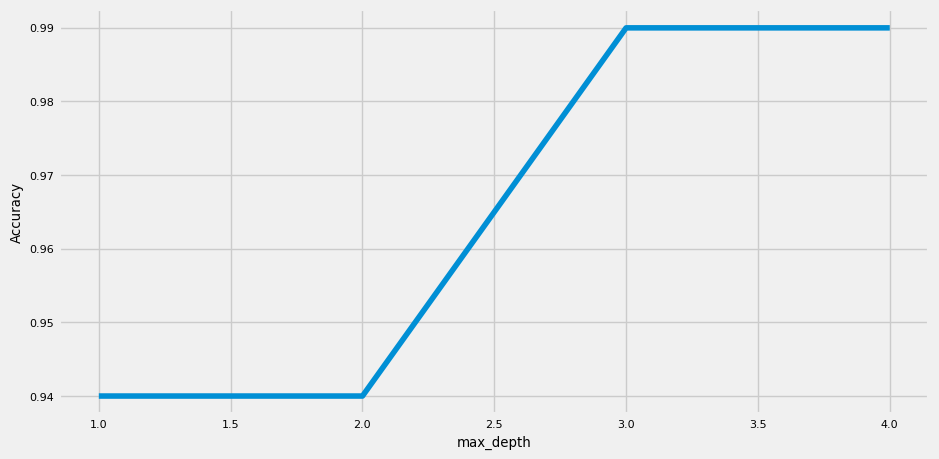

In [18]:
criterion='gini'
max_depth=None
min_samples_leaf=1
max_leaf_count=None
min_impurity_decrease=0.0

history = {
    'param_value': [],
    'accuracy': []
}

for max_depth in range(1, 5):
    tree = DecisionTreeClassifier(criterion=criterion,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  max_leaf_count=max_leaf_count,
                                  min_impurity_decrease=min_impurity_decrease)
    tree.fit(X, y)
    history["param_value"].append(max_depth)
    history["accuracy"].append(accuracy(y, tree.predict(X)))
    print('max_depth =', max_depth)
    print(tree)
    print('_'*100)

history = pd.DataFrame(history)
plot_history(history, "max_depth")

С увеличением глубины дерева увеличивается и точность, но решающие деревья переобучаются очень быстро и с этим параметром нужно быть акуратным

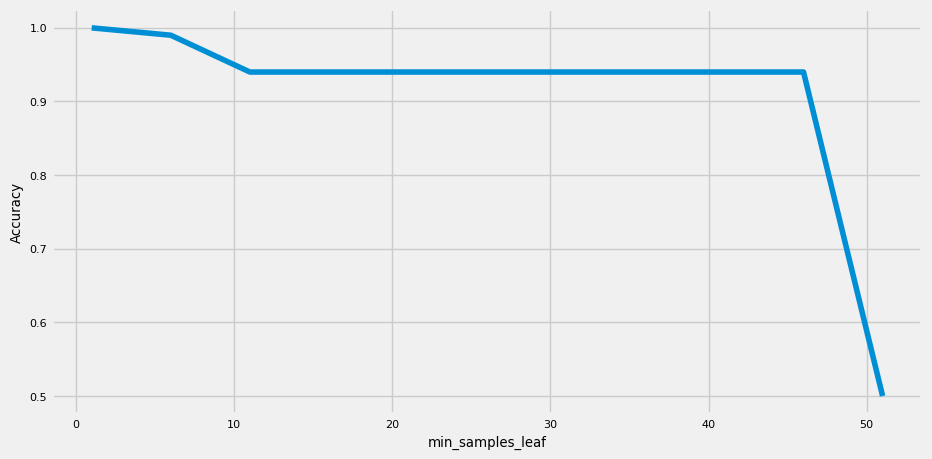

In [19]:
criterion='gini'
max_depth=None
min_samples_leaf=1
max_leaf_count=None
min_impurity_decrease=0.0

history = {
    'param_value': [],
    'accuracy': []
}

for min_samples_leaf in range(1, 55, 5):
    tree = DecisionTreeClassifier(criterion=criterion,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  max_leaf_count=max_leaf_count,
                                  min_impurity_decrease=min_impurity_decrease)
    tree.fit(X, y)
    history["param_value"].append(min_samples_leaf)
    history["accuracy"].append(accuracy(y, tree.predict(X)))

history = pd.DataFrame(history)
plot_history(history, "min_samples_leaf")

Увеличение min_samples_leaf ограничивает можель в том, сколько значений попадет в лист. С его увеличением размер дерева становится меньше

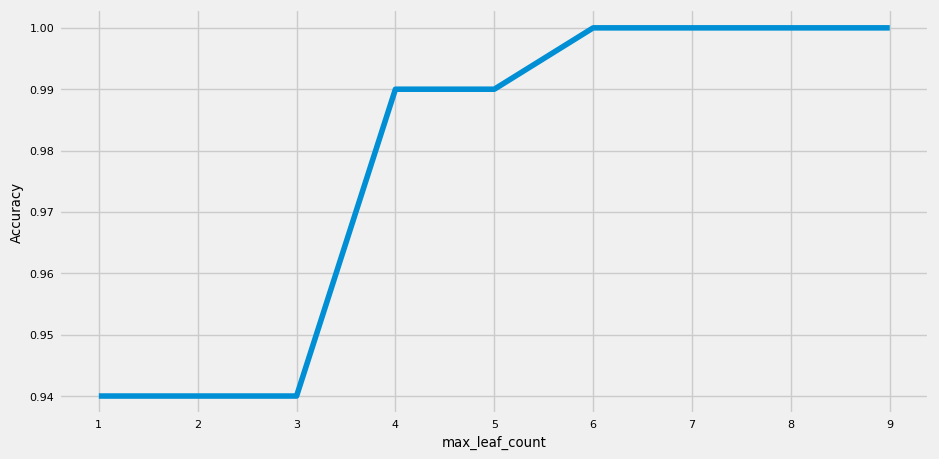

In [20]:
criterion='gini'
max_depth=None
min_samples_leaf=1
max_leaf_count=None
min_impurity_decrease=0.0

history = {
    'param_value': [],
    'accuracy': []
}

for max_leaf_count in range(1, 10):
    tree = DecisionTreeClassifier(criterion=criterion,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  max_leaf_count=max_leaf_count,
                                  min_impurity_decrease=min_impurity_decrease)
    tree.fit(X, y)
    history["param_value"].append(max_leaf_count)
    history["accuracy"].append(accuracy(y, tree.predict(X)))

history = pd.DataFrame(history)
plot_history(history, "max_leaf_count")

Увеличение количества листьев также увеличивает качество, но позволяет модели переобучиться

### Регрессия

In [21]:
def plot_history(history, param_name=""):
    plt.figure(figsize=(10, 5))
    plt.plot(history.param_value, history.r2_score)
    plt.xlabel(param_name)
    plt.ylabel('r2_score')
    plt.show()

In [22]:
def r2_score(y_true, y_pred):
    SSres = np.sum((y_true - y_pred)**2)
    SStot = np.sum((y_true - np.mean(y_pred))**2)
    return 1 - (SSres / SStot)

In [23]:
X, y = datasets.make_regression(n_samples=100, n_features=2, 
                                n_informative=2, n_targets=1,
                                noise=5, bias=0, # intersept=0
                                random_state=42)

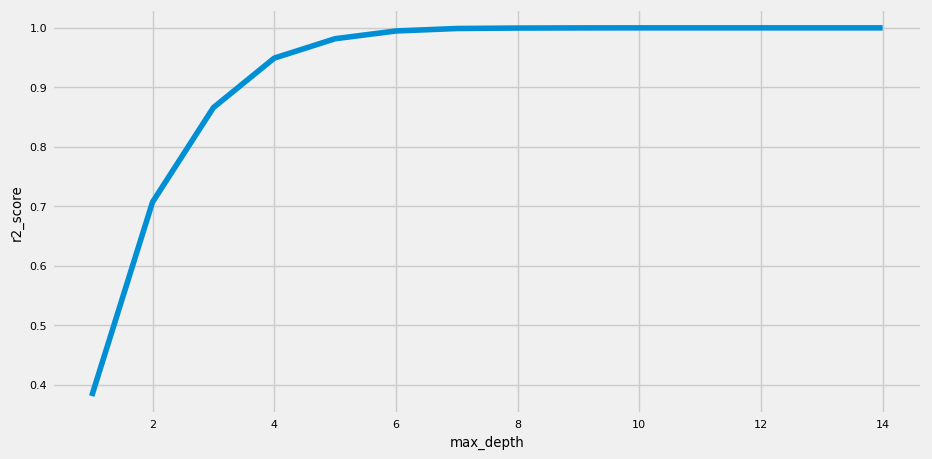

In [24]:
criterion='mse'
max_depth=None
min_samples_leaf=1
max_leaf_count=None
min_impurity_decrease=0.0

history = {
    'param_value': [],
    'r2_score': []
}

for max_depth in range(1, 15):
    tree = DecisionTreeRegressor(criterion=criterion,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 max_leaf_count=max_leaf_count,
                                 min_impurity_decrease=min_impurity_decrease)
    tree.fit(X, y)
    history["param_value"].append(max_depth)
    history["r2_score"].append(r2_score(y, tree.predict(X)))

history = pd.DataFrame(history)
plot_history(history, "max_depth")

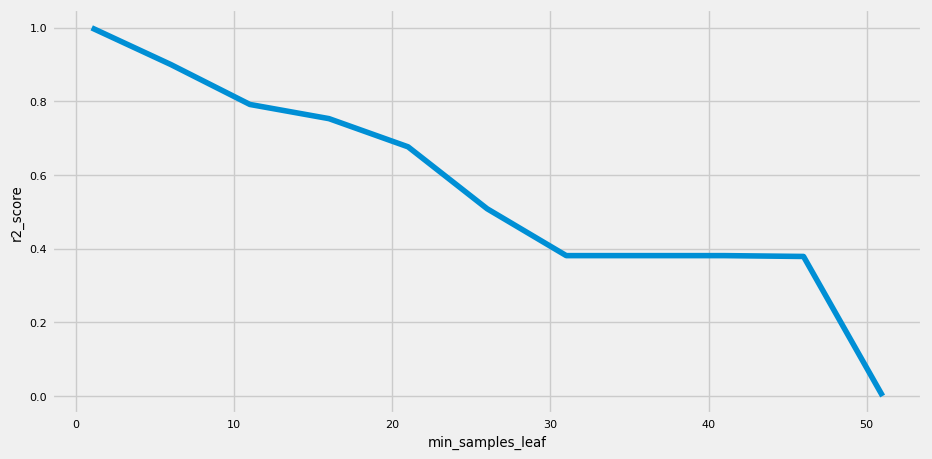

In [25]:
criterion='mse'
max_depth=None
min_samples_leaf=1
max_leaf_count=None
min_impurity_decrease=0.0

history = {
    'param_value': [],
    'r2_score': []
}

for min_samples_leaf in range(1, 55, 5):
    tree = DecisionTreeRegressor(criterion=criterion,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 max_leaf_count=max_leaf_count,
                                 min_impurity_decrease=min_impurity_decrease)
    tree.fit(X, y)
    history["param_value"].append(min_samples_leaf)
    history["r2_score"].append(r2_score(y, tree.predict(X)))

history = pd.DataFrame(history)
plot_history(history, "min_samples_leaf")

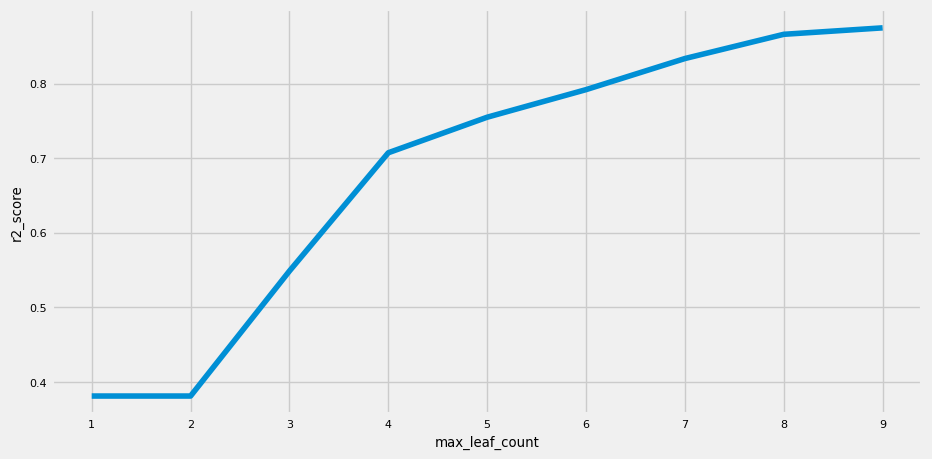

In [26]:
criterion='mse'
max_depth=None
min_samples_leaf=1
max_leaf_count=None
min_impurity_decrease=0.0

history = {
    'param_value': [],
    'r2_score': []
}

for max_leaf_count in range(1, 10):
    tree = DecisionTreeRegressor(criterion=criterion,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 max_leaf_count=max_leaf_count,
                                 min_impurity_decrease=min_impurity_decrease)
    tree.fit(X, y)
    history["param_value"].append(max_leaf_count)
    history["r2_score"].append(r2_score(y, tree.predict(X)))

history = pd.DataFrame(history)
plot_history(history, "max_leaf_count")

В задачах регрессии параметры влияют на дерево также как и в задачах классификации